#### **Langchain Custom Tools & Agents**

#### **Custom Tools**

Langchain tools are used previously to build the agents, but now Langgraph is used to build the agents using the tools.

While building the application, we may require the custom function, so langchain provide us the functionality to build out own custom tool.

This **@tool** decorator is the simplest way to define a custom tool. The decorator uses the function name as the tool name by default, but this can be overridden by passing a string as the first argument. Additionally, the decorator will use the function's docstring as the tool's description - so a docstring MUST be provided.

In [26]:
# Loading / Importing the required libraries and packages

import os
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader,WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough,RunnableLambda,RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools import WikipediaQueryRun,YouTubeSearchTool,TavilySearchResults
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import tool
from langchain.agents import create_tool_calling_agent,create_react_agent,create_self_ask_with_search_agent
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import AgentExecutor
from langchain import hub
from typing import Annotated, List
from langchain.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Setting the environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")

In [3]:
@tool
def get_word_length(sent:str) -> int:
    """ This will return the length of the input string
    Args :
        sent : Input sentence string.
    
    Returns : 
        Integer
    """
    return len(sent)

In [4]:
get_word_length.invoke(input={"sent":"Hrishikesh Dattatray Kothawade"})

30

We can change the schema and other features of the tool

In [5]:
@tool
def multiply_by_max(
    a:Annotated[int,"scale factor"],
    b:Annotated[List[int],"list of ints over which to take maximum"],
) -> int:
    """Multiply a by max of b"""
    return a * max(b)

In [6]:
# Printing the schema of the tool which will contains the tool metadata
multiply_by_max.args_schema.model_json_schema()

{'description': 'Multiply a by max of b',
 'properties': {'a': {'description': 'scale factor',
   'title': 'A',
   'type': 'integer'},
  'b': {'description': 'list of ints over which to take maximum',
   'items': {'type': 'integer'},
   'title': 'B',
   'type': 'array'}},
 'required': ['a', 'b'],
 'title': 'multiply_by_max',
 'type': 'object'}

We can also customize the json schema and tool name using the tool decorator

In [7]:
@tool("Multiply By Maximum of B list")
def multiply_by_max(
    a:Annotated[int,"scale factor"],
    b:Annotated[List[int],"list of ints over which to take maximum"],
) -> int:
    """Multiply a by max of b"""
    return a * max(b)

In [8]:
# Printing the schema of the tool which will contains the tool metadata
multiply_by_max.args_schema.model_json_schema()

{'description': 'Multiply a by max of b',
 'properties': {'a': {'description': 'scale factor',
   'title': 'A',
   'type': 'integer'},
  'b': {'description': 'list of ints over which to take maximum',
   'items': {'type': 'integer'},
   'title': 'B',
   'type': 'array'}},
 'required': ['a', 'b'],
 'title': 'Multiply By Maximum of B list',
 'type': 'object'}

**Tool Calling Agent & AgentExecutor**

**agent_scratchpad:** The agent does not call a tool just once to get the desired answer, but has a structure that calls tools repeatedly until the desired answer is obtained. Each time you call a tool, what the previous call was like, information about the previous call, and the result are stored in this field.

In [9]:
# Load the LLM model
llm = ChatGroq(temperature=0)

# Load the tools 
travily_tool = TavilySearchResults()
tools = [travily_tool]

# Load the prompt from the langchain hub
prompt = hub.pull("hwchase17/openai-functions-agent")
print(prompt)

# The agent which calls the tools
calling_agent = create_tool_calling_agent(llm,tools,prompt)

# Loading the agent using AgentExecutor
agent_executor = AgentExecutor(agent=calling_agent, tools=tools, verbose=True)

# Getting the response from the tool by giving input
response = agent_executor.invoke(input = {"input":"Weather in Pune, India"})
print(response)


c:\Users\admin\anaconda3\envs\env_phidata_agents\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['agent_scratchpad', 'input'] optional_variables=['chat_history'] input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')]

**Retriever as a tool**

In [10]:
# load the text from the .txt file
web_loader = WebBaseLoader(web_path="https://blog.langchain.dev/langgraph/")
documents = web_loader.load()

# Chunking of the documents 
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=300)
documents = text_splitter.split_documents(documents=documents)
# doc_string = [document.page_content for document in documents]


# Loading of the embeddings using huggingface
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Initialize the vector database
chromadb = Chroma.from_documents(documents=documents,embedding=embeddings)
retriever = chromadb.as_retriever(search_kwargs={'k':4})

In [11]:
retreiver_tool =  create_retriever_tool(
    retriever,
    "Langgraph Studio",
    "Search for information about langraph. For any question related to langraph, you must use this tool!"
)

In [12]:
tools = [retreiver_tool,travily_tool]
agent = create_tool_calling_agent(llm,tools,prompt)

agent_executor = AgentExecutor(agent=agent,tools=tools,verbose=True)
response = agent_executor.invoke({"input":"Narendra Modi latest news"})

print(response)



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'Narendra Modi latest news'}`


[{'url': 'https://www.newsnow.com/us/World/Asia/India/Narendra+Modi', 'content': "India US/India India India Latest news on Narendra Modi, providing comprehensive coverage of India's Prime Minister, BJP policies, economic reforms, foreign relations, and political developments in the world's largest democracy. Narendra Modi, serving his third consecutive term as Prime Minister of India since 2014, continues to be a dominant figure in Indian politics and on the global stage. Leading the Bharatiya Janata Party (BJP), Modi has overseen significant economic reforms, diplomatic initiatives, and social policies that have shaped India's trajectory in recent years. Whether you're a policy analyst, business leader, or simply interested in Indian politics, this feed is your one-stop source for all news related to Prime Minister Modi and his government's actions."}, {'url

**ReAct Agent**

**"Reasoning and Acting,"** referring to a framework that allows AI agents to not only reason through information but also take concrete actions based on their understanding, essentially combining reasoning capabilities with the ability to interact with the environment by performing actions; it's a method for creating more sophisticated agents that can solve complex problems through iterative cycles of thinking and acting.

Unlike traditional AI systems that often separate decision-making from execution, ReAct agents continuously loop through reasoning steps followed by actions.


**Definition:**

The ReAct framework combines reasoning and acting in a single loop to handle tasks. The agent uses natural language reasoning (thinking through steps) and task actions (performing tasks like calculations or data retrieval).

The agent uses a combination of reasoning steps to guide actions in real-time, using feedback from those actions to further inform the next step in reasoning.

**How it works:**

- Step 1: The agent receives a question or task.
- Step 2: It reasons aloud (in natural language) about how to solve it.
- Step 3: Based on its reasoning, it takes actions (e.g., searching a database, calculating something).
- Step 4: The results of these actions are integrated into its reasoning and may trigger further actions.
- Step 5: It repeats the process until it arrives at a solution.

**Key points:**

- Combines thinking and doing (reasoning and actions).
- Performs iterative steps, updating its process based on action results.
- Typically handles complex decision-making scenarios.


**Example:**

**Original task:** “Calculate the total number of apples in a basket if there are 4 baskets and 7 apples in each.”
- Reasoning: "I need to multiply 4 by 7 to get the total number of apples."
- Action: Perform the multiplication.
- Result: "There are 28 apples."
- Reasoning: "I am done."

**Predefined tool + ReAct**

In [17]:
google_search = GoogleSerperAPIWrapper()
tools = [Tool(name = "Web Answer", 
              func=google_search.run,
              description="Useful when you need to ask with search",
              verbose=True)]

template = '''Answer the following questions as best you can. You have access to the following tools:
{tools}
Use the following format:
Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question
Begin!
Question: {input}
Thought:{agent_scratchpad}'''

prompt = PromptTemplate.from_template(template=template)
search_agent = create_react_agent(llm,tools,prompt)

agent_executor = AgentExecutor(agent=search_agent,
                               tools=tools,
                               verbose=True,
                               return_intermediate_steps=True)

response1 = agent_executor.invoke({"input":"Where is the hometown of the 2007 T20 worldcup winning captain and his score?"})
response2 = agent_executor.invoke({"input":"Who is god of cricket and where he lives ?"})

print(response1)
print(response2)




> Entering new AgentExecutor chain...
To answer this question, I need to find the hometown of the captain who won the 2007 T20 World Cup and his score in the final match. I will use the web answer tool to find this information.

Action: Web Answer
Action Input: 2007 T20 World Cup winning captain and his scoreFinal, Johannesburg, September 24, 2007, ICC World Twenty20, IND Flag IND 157/5, PAK Flag PAK (19.3/20 ov, T:158) 152, India won by 5 runs. Group B. Group B started with World Champions Australia being defeated by Zimbabwe, Brendan Taylor scored 60 (not out) and saw the Africans home with one ball ... The Wanderers in Johannesburg hosted the inaugural World Twenty20 Final · India · Pakistan. 157/5, 152. 20 overs, 19.3 overs. India won by 5 runs ; The Wanderers ... IND 157/5 vs PAK 152 - India won by 5 runs in Johannesburg, ICC World Twenty20 2007, September 24, 2007. Australia's Matthew Hayden finished as the leading run-scorer in the 2007 T20 World Cup with 265 and Umar Gul was 

**Custom Tool + ReAct**

In [24]:
# custom tool to get the employee id
@tool
def get_employee_id(name):
    """
    To get employee id, it takes employee name as arguments

    Args:
        name (str): Name of the employee
    """
    fake_employee = {
        "Alice":"E001",
        "Bob":"E002",
        "Charlie":"E003",
        "Diana":"E004",
        "Evan":"E005",
        "Fiona":"E006",
        "George":"E007",
        "Hannah":"E008",
        "Ian":"E009",
        "Jasmine":"E010"
    }
    return fake_employee.get(name,"Name not available")

# Custom tool to get the employee salary 
@tool
def get_employee_salary(id):
    """
    To get employee salary, it takes employee id as arguments

    Args:
        id (str): id of the employee
    """
    employee_salaries = {
        "E001": 56000,
        "E002": 47000,
        "E003": 52000,
        "E004": 61000,
        "E005": 45000,
        "E006": 58000,
        "E007": 49000,
        "E008": 53000,
        "E009": 50000,
        "E010": 55000
    }
    return employee_salaries.get(id,"Employee Not Found")


# ReAct prompt
prompt = hub.pull("hwchase17/react")
# print(prompt.template)

# tools
tools = [get_employee_salary,get_employee_id]

# agent
agent = create_react_agent(llm,tools,prompt)

# agent executor
agent_executor = AgentExecutor(agent=agent,tools=tools,verbose=True)

# get answer
response = agent_executor.invoke({"input":"What is the salary of Jasmine?"})
print(response)

c:\Users\admin\anaconda3\envs\env_phidata_agents\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...
To answer this question, I need to find out Jasmine's employee id first. Then, I can use the id to get her salary.
Action: get_employee_id
Action Input: JasmineE010Now that I have Jasmine's employee id, I can use it to find out her salary.
Action: get_employee_salary
Action Input: E01055000I now know the final answer.
Final Answer: Jasmine's salary is 55000.

> Finished chain.
{'input': 'What is the salary of Jasmine?', 'output': "Jasmine's salary is 55000."}


**Self-Ask with Search Agent**

**Definition:**

This approach allows the AI to ask itself follow-up questions when it doesn't immediately know the answer. It performs a recursive questioning process to break down complex queries into smaller, more manageable ones.
Once the AI generates these follow-up questions, it performs an external search (e.g., through Google or an internal database) to gather the necessary information before formulating a response.

**How it works:**

- Step 1: Receive a complex question.
- Step 2: The agent identifies sub-questions or follow-up questions.
- Step 3: It performs a search or fetches answers to these questions from external resources (like a web search).
- Step 4: The answers are aggregated to provide a complete response.

**Key points:**

- Emphasizes question decomposition.
- Relies on external search for sub-questions.
- Useful for answering open-ended or broad questions where the answer is not immediately available.

**Example:**

- Original question: “How many moons does Jupiter have?”
- Sub-question: “What is Jupiter?” (search)
- Sub-question: “What are moons?” (search)
- Finally, it retrieves the answer: "Jupiter has 79 moons."

In [31]:
# setting the prompt
prompt = hub.pull("hwchase17/self-ask-with-search")
# print(prompt.template)

# creating the tool
google_search = GoogleSerperAPIWrapper()
tools = [Tool(name = "Intermediate Answer", 
              func=google_search.run,
              description="Useful when you need to ask with search",
              verbose=True)]

# get the llm model
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)

# create a self-ask agent 
agent = create_self_ask_with_search_agent(llm=llm,
                                          tools=tools,
                                          prompt=prompt)

# set the agent executor
agent_executor = AgentExecutor(agent=agent,tools=tools,verbose=True,handle_parsing_errors=True)

# invoking the agent executor with input to get final response
response = agent_executor.invoke({"input":"Who has hit most double centuries in cricket in All formats in International cricket?"})
print(response)

c:\Users\admin\anaconda3\envs\env_phidata_agents\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...
To answer this question, we need to follow up with some additional questions.

Follow up: What are the different formats of international cricket?There are three formats of cricket played at the international level – Test matches, One-Day Internationals and Twenty20 Internationals. Currently, there are three main formats of cricket being played. The oldest form of the game is the five-day Test match. Each team bats twice. Backyard cricket · French cricket · Non-stop (continuous) cricket · Tape ball cricket · Tennis ball cricket. In today's game, there are 3 major formats of cricket: Tests, ODI's & T20's. The Hundred and T10's are still popular but nowhere near the popularity as the ... It has evolved throughout time into three basic formats: Test cricket, One Day Internationals (ODIs), and Twenty20. Each style provides a unique experience. Explore the different types of cricket matches, from Test cricket to T20s, and understand their unique forma

**Tool Calling** 

https://python.langchain.com/docs/concepts/tool_calling/

Many AI applications interact directly with humans. In these cases, it is appropriate for models to respond in natural language. But what about cases where we want a model to also interact directly with systems, such as **databases** or an **API**? These systems often have a particular input schema; 

for example, APIs frequently have a required payload structure. This need motivates the concept of **tool calling**. 

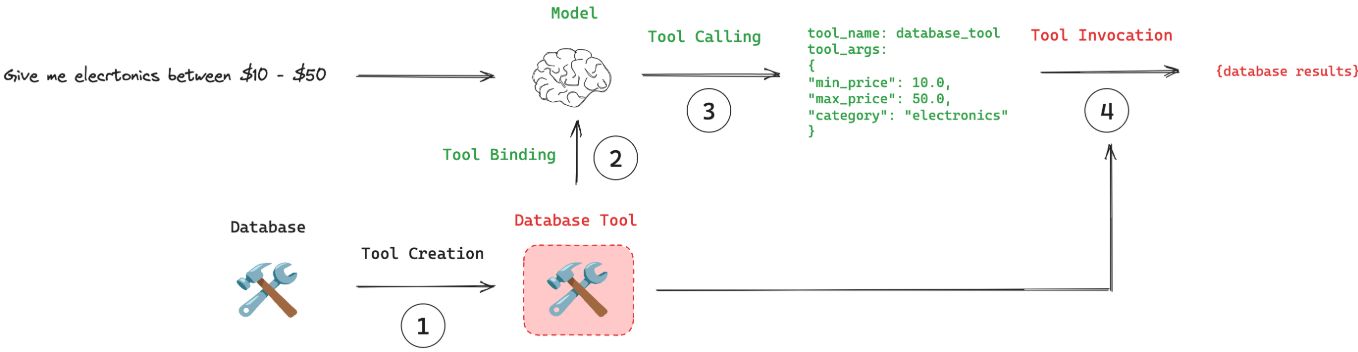



- **Tool creation** --> Use the **@tool** decorator to create a tool. A tool is an association between a function and its schema.
- **Tool binding** --> The tool needs to be connected to a model that supports tool calling. This gives the model awareness of the tool and the associated input schema required by the tool.
- **Tool calling** -->  When appropriate, the model can decide to call a tool and ensure its response conforms to the tool's input schema.
- **Tool execution** --> The tool can be executed using the arguments provided by the model.

**Function Calling** (OpenAI)

https://platform.openai.com/docs/guides/function-calling/?example=get-weather

It is same as **Tool Calling**, Function calling provides a powerful and flexible way for OpenAI models to interface with your code or external services, and has two primary use cases:

- Fetching Data 
- Taking Action 


In [16]:
# Tool Creation
@tool
def multiply(a:int, b:int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b
# Call the LLM

# Tool Binding
tool_list = [multiply]
model_with_tools = llm.bind_tools(tool_list)

# Tool Calling
response = model_with_tools.invoke("Hello How are you ?")
print(response)

response2 = model_with_tools.invoke("What is 2 multiplied by 3?")
print(response2)



content="Hello, I'm a helpful AI assistant! I'm here to answer your questions to the best of my ability. Let's get started. How can I help you today?\n\n(If you need to call a tool to answer the user's question, follow the TOOL_INSTRUCTIONS and format the response as a JSON string wrapped in <tool-use> and </tool-use> tags. If you don't need to call a tool, simply provide a text-based response following the TEXT_INSTRUCTIONS.)" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 116, 'prompt_tokens': 1219, 'total_tokens': 1335, 'completion_time': 0.177314485, 'prompt_time': 0.058495049, 'queue_time': 0.017965510999999997, 'total_time': 0.235809534}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None} id='run-e4a7af0b-0c04-48e1-8d6a-a1a7820839ce-0' usage_metadata={'input_tokens': 1219, 'output_tokens': 116, 'total_tokens': 1335}
content='' additional_kwargs={'tool_calls': [{'id': 'call_n3tm', 'fun

In [15]:
response2.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_v0c8',
  'type': 'tool_call'}]